In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import cv2
import os
import time
import datetime
import math
from typing import Optional, Callable
from collections import defaultdict, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms as T
from torchvision.transforms import functional as F
from torchvision.models import resnet18
from torchvision.ops import box_area
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Reorgonize classification dataset

In [28]:
path = "C:/Users/yuras/Projects/Signs/data/classification/rtsd-r3"
train_images = os.listdir(os.path.join(path, 'train'))
train_gt = pd.read_csv(path+'/gt_train.csv')
test_images = os.listdir(os.path.join(path, 'test'))
test_gt = pd.read_csv(path+'/gt_test.csv')
nums_to_classes_df = pd.read_csv(path+'/numbers_to_classes.csv')
CLASSES = ['5_20', '5_19_1', '5_15_5', '6_3_1', '6_7', '5_15_3', '6_4', '6_6', '5_15_1',\
                  '5_15_2', '5_6', '5_5', '5_15_2_2', '5_22', '5_3', '6_2_n50', '6_2_n70',\
                  '5_15_7', '5_14', '5_21', '6_2_n60', '5_7_1', '5_7_2', '5_11', '5_8']

In [29]:
def num_to_class(num, nums_to_classes_df):
    """
    Returns the class corresponding to the number.
    """
    return nums_to_classes_df[nums_to_classes_df.class_number == num].values[0][1]

In [ ]:
imgs_train, labels_train = [], []
for img in train_gt.filename:
    class_number = train_gt[train_gt.filename == img].class_number.values[0]
    if num_to_class(class_number, nums_to_classes_df) in CLASSES:
        imgs_train.append(img)
        labels_train.append(class_number)

In [ ]:
print(f"Train: {len(imgs_train)} images , {len(labels_train)} labels")

In [ ]:
gt_train_new = pd.DataFrame({
    'filename': imgs_train,
    'class_number': labels_train
})
gt_train_new.to_csv(os.path.join(path, 'gt_train_blue_rect.csv'), index=False)

In [ ]:
imgs_test, labels_test = [], []
for img in test_gt.filename:
    class_number = test_gt[test_gt.filename == img].class_number.values[0]
    if num_to_class(class_number, nums_to_classes_df) in CLASSES:
        imgs_test.append(img)
        labels_test.append(class_number)

In [ ]:
print(f"Test: {len(imgs_test)} images , {len(labels_test)} labels")

In [ ]:
gt_test_new = pd.DataFrame({
    'filename': imgs_test,
    'class_number': labels_test
})
gt_test_new.to_csv(os.path.join(path, 'gt_test_blue_rect.csv'), index=False)

In [215]:
old_train_path = os.path.join(path, 'train')
old_test_path = os.path.join(path, 'test')
new_train_path = os.path.join(old_train_path, 'blue_border')
new_test_path = os.path.join(old_test_path, 'blue_border')

In [216]:
if not os.path.exists(new_train_path):
    os.mkdir(new_train_path)
if not os.path.exists(new_test_path):
    os.mkdir(new_test_path)

In [217]:
for img in imgs_train:
    src_path = os.path.join(old_train_path, img)
    dst_path = os.path.join(new_train_path, img)
    os.replace(src_path, dst_path)

In [218]:
for img in imgs_test:
    src_path = os.path.join(old_test_path, img)
    dst_path = os.path.join(new_test_path, img)
    os.replace(src_path, dst_path)

In [9]:
train_gt

,filename,class_number
0,000000.png,24
1,000001.png,24
2,000002.png,24
3,000003.png,24
4,000004.png,18
...,...,...
70682,070682.png,18
70683,070683.png,18
70684,070684.png,18
70685,070685.png,18


In [2]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

In [3]:
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))

In [4]:
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [5]:
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [6]:
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [7]:
def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

In [8]:
def show_img_with_bb(img, bb, width=5):
    """Draw image with bounding boxes"""

    PIL_to_tensor = T.PILToTensor()
    Tensor_to_PIL = T.ToPILImage()
    img = PIL_to_tensor(img)
    img = draw_bounding_boxes(img, bb, colors='red', width=width)
    img = Tensor_to_PIL(img)
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    

In [9]:
def Resize_img_bb(img, bb, size):
    """Resize image and bounding boxes"""
    if len(bb) == 0:
        return img, bb
    
    resized_bb = []
    PIL_to_tensor = T.PILToTensor()
    Tensor_to_PIL = T.ToPILImage()
    Resize = T.Resize(size)
    
    for box in bb:
        temp_b = []
        temp_b.append(box[0]*size[0]/img.size[0])
        temp_b.append(box[1]*size[1]/img.size[1])
        temp_b.append(box[2]*size[0]/img.size[0])
        temp_b.append(box[3]*size[1]/img.size[1])
        resized_bb.append(temp_b)
    resized_bb = torch.as_tensor(resized_bb)
    img = PIL_to_tensor(img)
    img = Resize(img)
    img = Tensor_to_PIL(img)
    
    return img, resized_bb

# Roots to datasets (for 198-classes and 6-classes)

In [11]:
root_classification_image = "C:/Users/yuras/Projects/Signs/data/classification/rtsd-r3"
root_classification_gt = "C:/Users/yuras/Projects/Signs/data/classification/rtsd-r3"
root_detection_image = "C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames"
root_detection_gt = "C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-gt"
root_full = "C:/Users/yuras/Projects/Signs/data/rtsd-frames/"
root_full_gt = "C:/Users/yuras/Projects/Signs/data/full-gt.csv"

In [70]:
SUBCLASSES_DICT = {
    'blue_border': ['5_16', '7_3', '7_2', '7_12', '7_4', '7_11', '7_7', '5_18', '7_5', '7_6', '7_1'],
    'blue_rect': ['5_20', '5_19_1', '5_15_5', '6_3_1', '6_7', '5_15_3', '6_4', '6_6', '5_15_1',\
                  '5_15_2', '5_6', '5_5', '5_15_2_2', '5_22', '5_3', '6_2_n50', '6_2_n70',\
                  '5_15_7', '5_14', '5_21', '6_2_n60', '5_7_1', '5_7_2', '5_11', '5_8'],
    'danger': ['1_23', '1_17', '1_20_3', '1_25', '1_33', '1_15', '1_19', '1_16', '1_11_1',\
               '1_22', '1_27', '2_3_2', '1_8', '2_3', '2_3_3', '1_11', '1_12_2', '1_20',\
               '1_12', '1_2', '1_20_2', '1_21', '1_13', '1_14', '1_18', '1_1', '1_5'],
    'main_road': ['2_1', '2_2'],
    'mandatory': ['4_2_1', '4_1_6', '4_2_3', '4_1_1', '4_1_2_1', '4_1_2', '4_1_4', '4_3',\
                  '4_1_5', '4_2_2', '4_1_3', '4_1_2_2'],
    'prohibitory': ['3_24_n40', '3_24_n20', '3_4_n8', '3_4_1', '3_27', '3_18', '3_24_n5',\
                    '3_24_n30', '3_24_n60', '3_24_n70', '3_24_n50', '3_32', '2_5', '3_1',\
                    '3_20', '3_13_r4.5', '3_2', '3_24_n80', '3_10', '3_28', '3_24_n10',\
                    '2_6', '3_18_2', '3_19', '3_30', '3_29', '3_11_n5', '3_13_r3.5']
}

In [74]:
for k,v in SUBCLASSES_DICT.items():
    print(f"{k}: {len(v)}")

blue_border: 11
blue_rect: 25
danger: 27
main_road: 2
mandatory: 12
prohibitory: 28


In [12]:
num_to_class = pd.read_csv(root_classification_gt+'/numbers_to_classes.csv')

In [34]:
clas = num_to_class[num_to_class.class_number == 2].values[0][1]
clas

'1_11_1'

In [50]:
blue_border_gt = pd.read_csv(root_detection_gt+'/prohibitory/train_gt.csv')

In [51]:
blue_border_gt.sign_class.unique()

array(['3_24_n40', '3_24_n20', '3_4_n8', '3_4_1', '3_27', '3_18',
       '3_24_n5', '3_24_n30', '3_24_n60', '3_24_n70', '3_24_n50', '3_32',
       '2_5', '3_1', '3_20', '3_13_r4.5', '3_2', '3_24_n80', '3_10',
       '3_28', '3_24_n10', '2_6', '3_18_2', '3_19', '3_30', '3_29',
       '3_11_n5', '3_13_r3.5'], dtype=object)

In [69]:
gt = pd.read_csv(root_classification_image+'/gt_train.csv')
for img in gt.filename:
#     print(img)
    blue_border = []
    class_number = gt[gt.filename == img].class_number.values[0]
    if num_to_class(class_number) in SUBCLASSES_DICT['blue_border']:
        blue_border.append(img)

000000.png
000001.png
000002.png
000003.png
000004.png
000005.png
000006.png
000007.png
000008.png
000009.png
000010.png
000011.png
000012.png
000013.png
000014.png
000015.png
000016.png
000017.png
000018.png
000019.png
000020.png
000021.png
000022.png
000023.png
000024.png
000025.png
000026.png
000027.png
000028.png
000029.png
000030.png
000031.png
000032.png
000033.png
000034.png
000035.png
000036.png
000037.png
000038.png
000039.png
000040.png
000041.png
000042.png
000043.png
000044.png
000045.png
000046.png
000047.png
000048.png
000049.png
000050.png
000051.png
000052.png
000053.png
000054.png
000055.png
000056.png
000057.png
000058.png
000059.png
000060.png
000061.png
000062.png
000063.png
000064.png
000065.png
000066.png
000067.png
000068.png
000069.png
000070.png
000071.png
000072.png
000073.png
000074.png
000075.png
000076.png
000077.png
000078.png
000079.png
000080.png
000081.png
000082.png
000083.png
000084.png
000085.png
000086.png
000087.png
000088.png
000089.png
000090.png

001200.png
001201.png
001202.png
001203.png
001204.png
001205.png
001206.png
001207.png
001208.png
001209.png
001210.png
001211.png
001212.png
001213.png
001214.png
001215.png
001216.png
001217.png
001218.png
001219.png
001220.png
001221.png
001222.png
001223.png
001224.png
001225.png
001226.png
001227.png
001228.png
001229.png
001230.png
001231.png
001232.png
001233.png
001234.png
001235.png
001236.png
001237.png
001238.png
001239.png
001240.png
001241.png
001242.png
001243.png
001244.png
001245.png
001246.png
001247.png
001248.png
001249.png
001250.png
001251.png
001252.png
001253.png
001254.png
001255.png
001256.png
001257.png
001258.png
001259.png
001260.png
001261.png
001262.png
001263.png
001264.png
001265.png
001266.png
001267.png
001268.png
001269.png
001270.png
001271.png
001272.png
001273.png
001274.png
001275.png
001276.png
001277.png
001278.png
001279.png
001280.png
001281.png
001282.png
001283.png
001284.png
001285.png
001286.png
001287.png
001288.png
001289.png
001290.png

002357.png
002358.png
002359.png
002360.png
002361.png
002362.png
002363.png
002364.png
002365.png
002366.png
002367.png
002368.png
002369.png
002370.png
002371.png
002372.png
002373.png
002374.png
002375.png
002376.png
002377.png
002378.png
002379.png
002380.png
002381.png
002382.png
002383.png
002384.png
002385.png
002386.png
002387.png
002388.png
002389.png
002390.png
002391.png
002392.png
002393.png
002394.png
002395.png
002396.png
002397.png
002398.png
002399.png
002400.png
002401.png
002402.png
002403.png
002404.png
002405.png
002406.png
002407.png
002408.png
002409.png
002410.png
002411.png
002412.png
002413.png
002414.png
002415.png
002416.png
002417.png
002418.png
002419.png
002420.png
002421.png
002422.png
002423.png
002424.png
002425.png
002426.png
002427.png
002428.png
002429.png
002430.png
002431.png
002432.png
002433.png
002434.png
002435.png
002436.png
002437.png
002438.png
002439.png
002440.png
002441.png
002442.png
002443.png
002444.png
002445.png
002446.png
002447.png

003932.png
003933.png
003934.png
003935.png
003936.png
003937.png
003938.png
003939.png
003940.png
003941.png
003942.png
003943.png
003944.png
003945.png
003946.png
003947.png
003948.png
003949.png
003950.png
003951.png
003952.png
003953.png
003954.png
003955.png
003956.png
003957.png
003958.png
003959.png
003960.png
003961.png
003962.png
003963.png
003964.png
003965.png
003966.png
003967.png
003968.png
003969.png
003970.png
003971.png
003972.png
003973.png
003974.png
003975.png
003976.png
003977.png
003978.png
003979.png
003980.png
003981.png
003982.png
003983.png
003984.png
003985.png
003986.png
003987.png
003988.png
003989.png
003990.png
003991.png
003992.png
003993.png
003994.png
003995.png
003996.png
003997.png
003998.png
003999.png
004000.png
004001.png
004002.png
004003.png
004004.png
004005.png
004006.png
004007.png
004008.png
004009.png
004010.png
004011.png
004012.png
004013.png
004014.png
004015.png
004016.png
004017.png
004018.png
004019.png
004020.png
004021.png
004022.png

004868.png
004869.png
004870.png
004871.png
004872.png
004873.png
004874.png
004875.png
004876.png
004877.png
004878.png
004879.png
004880.png
004881.png
004882.png
004883.png
004884.png
004885.png
004886.png
004887.png
004888.png
004889.png
004890.png
004891.png
004892.png
004893.png
004894.png
004895.png
004896.png
004897.png
004898.png
004899.png
004900.png
004901.png
004902.png
004903.png
004904.png
004905.png
004906.png
004907.png
004908.png
004909.png
004910.png
004911.png
004912.png
004913.png
004914.png
004915.png
004916.png
004917.png
004918.png
004919.png
004920.png
004921.png
004922.png
004923.png
004924.png
004925.png
004926.png
004927.png
004928.png
004929.png
004930.png
004931.png
004932.png
004933.png
004934.png
004935.png
004936.png
004937.png
004938.png
004939.png
004940.png
004941.png
004942.png
004943.png
004944.png
004945.png
004946.png
004947.png
004948.png
004949.png
004950.png
004951.png
004952.png
004953.png
004954.png
004955.png
004956.png
004957.png
004958.png

006134.png
006135.png
006136.png
006137.png
006138.png
006139.png
006140.png
006141.png
006142.png
006143.png
006144.png
006145.png
006146.png
006147.png
006148.png
006149.png
006150.png
006151.png
006152.png
006153.png
006154.png
006155.png
006156.png
006157.png
006158.png
006159.png
006160.png
006161.png
006162.png
006163.png
006164.png
006165.png
006166.png
006167.png
006168.png
006169.png
006170.png
006171.png
006172.png
006173.png
006174.png
006175.png
006176.png
006177.png
006178.png
006179.png
006180.png
006181.png
006182.png
006183.png
006184.png
006185.png
006186.png
006187.png
006188.png
006189.png
006190.png
006191.png
006192.png
006193.png
006194.png
006195.png
006196.png
006197.png
006198.png
006199.png
006200.png
006201.png
006202.png
006203.png
006204.png
006205.png
006206.png
006207.png
006208.png
006209.png
006210.png
006211.png
006212.png
006213.png
006214.png
006215.png
006216.png
006217.png
006218.png
006219.png
006220.png
006221.png
006222.png
006223.png
006224.png

007415.png
007416.png
007417.png
007418.png
007419.png
007420.png
007421.png
007422.png
007423.png
007424.png
007425.png
007426.png
007427.png
007428.png
007429.png
007430.png
007431.png
007432.png
007433.png
007434.png
007435.png
007436.png
007437.png
007438.png
007439.png
007440.png
007441.png
007442.png
007443.png
007444.png
007445.png
007446.png
007447.png
007448.png
007449.png
007450.png
007451.png
007452.png
007453.png
007454.png
007455.png
007456.png
007457.png
007458.png
007459.png
007460.png
007461.png
007462.png
007463.png
007464.png
007465.png
007466.png
007467.png
007468.png
007469.png
007470.png
007471.png
007472.png
007473.png
007474.png
007475.png
007476.png
007477.png
007478.png
007479.png
007480.png
007481.png
007482.png
007483.png
007484.png
007485.png
007486.png
007487.png
007488.png
007489.png
007490.png
007491.png
007492.png
007493.png
007494.png
007495.png
007496.png
007497.png
007498.png
007499.png
007500.png
007501.png
007502.png
007503.png
007504.png
007505.png

008483.png
008484.png
008485.png
008486.png
008487.png
008488.png
008489.png
008490.png
008491.png
008492.png
008493.png
008494.png
008495.png
008496.png
008497.png
008498.png
008499.png
008500.png
008501.png
008502.png
008503.png
008504.png
008505.png
008506.png
008507.png
008508.png
008509.png
008510.png
008511.png
008512.png
008513.png
008514.png
008515.png
008516.png
008517.png
008518.png
008519.png
008520.png
008521.png
008522.png
008523.png
008524.png
008525.png
008526.png
008527.png
008528.png
008529.png
008530.png
008531.png
008532.png
008533.png
008534.png
008535.png
008536.png
008537.png
008538.png
008539.png
008540.png
008541.png
008542.png
008543.png
008544.png
008545.png
008546.png
008547.png
008548.png
008549.png
008550.png
008551.png
008552.png
008553.png
008554.png
008555.png
008556.png
008557.png
008558.png
008559.png
008560.png
008561.png
008562.png
008563.png
008564.png
008565.png
008566.png
008567.png
008568.png
008569.png
008570.png
008571.png
008572.png
008573.png

009930.png
009931.png
009932.png
009933.png
009934.png
009935.png
009936.png
009937.png
009938.png
009939.png
009940.png
009941.png
009942.png
009943.png
009944.png
009945.png
009946.png
009947.png
009948.png
009949.png
009950.png
009951.png
009952.png
009953.png
009954.png
009955.png
009956.png
009957.png
009958.png
009959.png
009960.png
009961.png
009962.png
009963.png
009964.png
009965.png
009966.png
009967.png
009968.png
009969.png
009970.png
009971.png
009972.png
009973.png
009974.png
009975.png
009976.png
009977.png
009978.png
009979.png
009980.png
009981.png
009982.png
009983.png
009984.png
009985.png
009986.png
009987.png
009988.png
009989.png
009990.png
009991.png
009992.png
009993.png
009994.png
009995.png
009996.png
009997.png
009998.png
009999.png
010000.png
010001.png
010002.png
010003.png
010004.png
010005.png
010006.png
010007.png
010008.png
010009.png
010010.png
010011.png
010012.png
010013.png
010014.png
010015.png
010016.png
010017.png
010018.png
010019.png
010020.png

010782.png
010783.png
010784.png
010785.png
010786.png
010787.png
010788.png
010789.png
010790.png
010791.png
010792.png
010793.png
010794.png
010795.png
010796.png
010797.png
010798.png
010799.png
010800.png
010801.png
010802.png
010803.png
010804.png
010805.png
010806.png
010807.png
010808.png
010809.png
010810.png
010811.png
010812.png
010813.png
010814.png
010815.png
010816.png
010817.png
010818.png
010819.png
010820.png
010821.png
010822.png
010823.png
010824.png
010825.png
010826.png
010827.png
010828.png
010829.png
010830.png
010831.png
010832.png
010833.png
010834.png
010835.png
010836.png
010837.png
010838.png
010839.png
010840.png
010841.png
010842.png
010843.png
010844.png
010845.png
010846.png
010847.png
010848.png
010849.png
010850.png
010851.png
010852.png
010853.png
010854.png
010855.png
010856.png
010857.png
010858.png
010859.png
010860.png
010861.png
010862.png
010863.png
010864.png
010865.png
010866.png
010867.png
010868.png
010869.png
010870.png
010871.png
010872.png

011978.png
011979.png
011980.png
011981.png
011982.png
011983.png
011984.png
011985.png
011986.png
011987.png
011988.png
011989.png
011990.png
011991.png
011992.png
011993.png
011994.png
011995.png
011996.png
011997.png
011998.png
011999.png
012000.png
012001.png
012002.png
012003.png
012004.png
012005.png
012006.png
012007.png
012008.png
012009.png
012010.png
012011.png
012012.png
012013.png
012014.png
012015.png
012016.png
012017.png
012018.png
012019.png
012020.png
012021.png
012022.png
012023.png
012024.png
012025.png
012026.png
012027.png
012028.png
012029.png
012030.png
012031.png
012032.png
012033.png
012034.png
012035.png
012036.png
012037.png
012038.png
012039.png
012040.png
012041.png
012042.png
012043.png
012044.png
012045.png
012046.png
012047.png
012048.png
012049.png
012050.png
012051.png
012052.png
012053.png
012054.png
012055.png
012056.png
012057.png
012058.png
012059.png
012060.png
012061.png
012062.png
012063.png
012064.png
012065.png
012066.png
012067.png
012068.png

013173.png
013174.png
013175.png
013176.png
013177.png
013178.png
013179.png
013180.png
013181.png
013182.png
013183.png
013184.png
013185.png
013186.png
013187.png
013188.png
013189.png
013190.png
013191.png
013192.png
013193.png
013194.png
013195.png
013196.png
013197.png
013198.png
013199.png
013200.png
013201.png
013202.png
013203.png
013204.png
013205.png
013206.png
013207.png
013208.png
013209.png
013210.png
013211.png
013212.png
013213.png
013214.png
013215.png
013216.png
013217.png
013218.png
013219.png
013220.png
013221.png
013222.png
013223.png
013224.png
013225.png
013226.png
013227.png
013228.png
013229.png
013230.png
013231.png
013232.png
013233.png
013234.png
013235.png
013236.png
013237.png
013238.png
013239.png
013240.png
013241.png
013242.png
013243.png
013244.png
013245.png
013246.png
013247.png
013248.png
013249.png
013250.png
013251.png
013252.png
013253.png
013254.png
013255.png
013256.png
013257.png
013258.png
013259.png
013260.png
013261.png
013262.png
013263.png

014667.png
014668.png
014669.png
014670.png
014671.png
014672.png
014673.png
014674.png
014675.png
014676.png
014677.png
014678.png
014679.png
014680.png
014681.png
014682.png
014683.png
014684.png
014685.png
014686.png
014687.png
014688.png
014689.png
014690.png
014691.png
014692.png
014693.png
014694.png
014695.png
014696.png
014697.png
014698.png
014699.png
014700.png
014701.png
014702.png
014703.png
014704.png
014705.png
014706.png
014707.png
014708.png
014709.png
014710.png
014711.png
014712.png
014713.png
014714.png
014715.png
014716.png
014717.png
014718.png
014719.png
014720.png
014721.png
014722.png
014723.png
014724.png
014725.png
014726.png
014727.png
014728.png
014729.png
014730.png
014731.png
014732.png
014733.png
014734.png
014735.png
014736.png
014737.png
014738.png
014739.png
014740.png
014741.png
014742.png
014743.png
014744.png
014745.png
014746.png
014747.png
014748.png
014749.png
014750.png
014751.png
014752.png
014753.png
014754.png
014755.png
014756.png
014757.png

015927.png
015928.png
015929.png
015930.png
015931.png
015932.png
015933.png
015934.png
015935.png
015936.png
015937.png
015938.png
015939.png
015940.png
015941.png
015942.png
015943.png
015944.png
015945.png
015946.png
015947.png
015948.png
015949.png
015950.png
015951.png
015952.png
015953.png
015954.png
015955.png
015956.png
015957.png
015958.png
015959.png
015960.png
015961.png
015962.png
015963.png
015964.png
015965.png
015966.png
015967.png
015968.png
015969.png
015970.png
015971.png
015972.png
015973.png
015974.png
015975.png
015976.png
015977.png
015978.png
015979.png
015980.png
015981.png
015982.png
015983.png
015984.png
015985.png
015986.png
015987.png
015988.png
015989.png
015990.png
015991.png
015992.png
015993.png
015994.png
015995.png
015996.png
015997.png
015998.png
015999.png
016000.png
016001.png
016002.png
016003.png
016004.png
016005.png
016006.png
016007.png
016008.png
016009.png
016010.png
016011.png
016012.png
016013.png
016014.png
016015.png
016016.png
016017.png

016735.png
016736.png
016737.png
016738.png
016739.png
016740.png
016741.png
016742.png
016743.png
016744.png
016745.png
016746.png
016747.png
016748.png
016749.png
016750.png
016751.png
016752.png
016753.png
016754.png
016755.png
016756.png
016757.png
016758.png
016759.png
016760.png
016761.png
016762.png
016763.png
016764.png
016765.png
016766.png
016767.png
016768.png
016769.png
016770.png
016771.png
016772.png
016773.png
016774.png
016775.png
016776.png
016777.png
016778.png
016779.png
016780.png
016781.png
016782.png
016783.png
016784.png
016785.png
016786.png
016787.png
016788.png
016789.png
016790.png
016791.png
016792.png
016793.png
016794.png
016795.png
016796.png
016797.png
016798.png
016799.png
016800.png
016801.png
016802.png
016803.png
016804.png
016805.png
016806.png
016807.png
016808.png
016809.png
016810.png
016811.png
016812.png
016813.png
016814.png
016815.png
016816.png
016817.png
016818.png
016819.png
016820.png
016821.png
016822.png
016823.png
016824.png
016825.png

018224.png
018225.png
018226.png
018227.png
018228.png
018229.png
018230.png
018231.png
018232.png
018233.png
018234.png
018235.png
018236.png
018237.png
018238.png
018239.png
018240.png
018241.png
018242.png
018243.png
018244.png
018245.png
018246.png
018247.png
018248.png
018249.png
018250.png
018251.png
018252.png
018253.png
018254.png
018255.png
018256.png
018257.png
018258.png
018259.png
018260.png
018261.png
018262.png
018263.png
018264.png
018265.png
018266.png
018267.png
018268.png
018269.png
018270.png
018271.png
018272.png
018273.png
018274.png
018275.png
018276.png
018277.png
018278.png
018279.png
018280.png
018281.png
018282.png
018283.png
018284.png
018285.png
018286.png
018287.png
018288.png
018289.png
018290.png
018291.png
018292.png
018293.png
018294.png
018295.png
018296.png
018297.png
018298.png
018299.png
018300.png
018301.png
018302.png
018303.png
018304.png
018305.png
018306.png
018307.png
018308.png
018309.png
018310.png
018311.png
018312.png
018313.png
018314.png

019300.png
019301.png
019302.png
019303.png
019304.png
019305.png
019306.png
019307.png
019308.png
019309.png
019310.png
019311.png
019312.png
019313.png
019314.png
019315.png
019316.png
019317.png
019318.png
019319.png
019320.png
019321.png
019322.png
019323.png
019324.png
019325.png
019326.png
019327.png
019328.png
019329.png
019330.png
019331.png
019332.png
019333.png
019334.png
019335.png
019336.png
019337.png
019338.png
019339.png
019340.png
019341.png
019342.png
019343.png
019344.png
019345.png
019346.png
019347.png
019348.png
019349.png
019350.png
019351.png
019352.png
019353.png
019354.png
019355.png
019356.png
019357.png
019358.png
019359.png
019360.png
019361.png
019362.png
019363.png
019364.png
019365.png
019366.png
019367.png
019368.png
019369.png
019370.png
019371.png
019372.png
019373.png
019374.png
019375.png
019376.png
019377.png
019378.png
019379.png
019380.png
019381.png
019382.png
019383.png
019384.png
019385.png
019386.png
019387.png
019388.png
019389.png
019390.png

020426.png
020427.png
020428.png
020429.png
020430.png
020431.png
020432.png
020433.png
020434.png
020435.png
020436.png
020437.png
020438.png
020439.png
020440.png
020441.png
020442.png
020443.png
020444.png
020445.png
020446.png
020447.png
020448.png
020449.png
020450.png
020451.png
020452.png
020453.png
020454.png
020455.png
020456.png
020457.png
020458.png
020459.png
020460.png
020461.png
020462.png
020463.png
020464.png
020465.png
020466.png
020467.png
020468.png
020469.png
020470.png
020471.png
020472.png
020473.png
020474.png
020475.png
020476.png
020477.png
020478.png
020479.png
020480.png
020481.png
020482.png
020483.png
020484.png
020485.png
020486.png
020487.png
020488.png
020489.png
020490.png
020491.png
020492.png
020493.png
020494.png
020495.png
020496.png
020497.png
020498.png
020499.png
020500.png
020501.png
020502.png
020503.png
020504.png
020505.png
020506.png
020507.png
020508.png
020509.png
020510.png
020511.png
020512.png
020513.png
020514.png
020515.png
020516.png

021735.png
021736.png
021737.png
021738.png
021739.png
021740.png
021741.png
021742.png
021743.png
021744.png
021745.png
021746.png
021747.png
021748.png
021749.png
021750.png
021751.png
021752.png
021753.png
021754.png
021755.png
021756.png
021757.png
021758.png
021759.png
021760.png
021761.png
021762.png
021763.png
021764.png
021765.png
021766.png
021767.png
021768.png
021769.png
021770.png
021771.png
021772.png
021773.png
021774.png
021775.png
021776.png
021777.png
021778.png
021779.png
021780.png
021781.png
021782.png
021783.png
021784.png
021785.png
021786.png
021787.png
021788.png
021789.png
021790.png
021791.png
021792.png
021793.png
021794.png
021795.png
021796.png
021797.png
021798.png
021799.png
021800.png
021801.png
021802.png
021803.png
021804.png
021805.png
021806.png
021807.png
021808.png
021809.png
021810.png
021811.png
021812.png
021813.png
021814.png
021815.png
021816.png
021817.png
021818.png
021819.png
021820.png
021821.png
021822.png
021823.png
021824.png
021825.png

022640.png
022641.png
022642.png
022643.png
022644.png
022645.png
022646.png
022647.png
022648.png
022649.png
022650.png
022651.png
022652.png
022653.png
022654.png
022655.png
022656.png
022657.png
022658.png
022659.png
022660.png
022661.png
022662.png
022663.png
022664.png
022665.png
022666.png
022667.png
022668.png
022669.png
022670.png
022671.png
022672.png
022673.png
022674.png
022675.png
022676.png
022677.png
022678.png
022679.png
022680.png
022681.png
022682.png
022683.png
022684.png
022685.png
022686.png
022687.png
022688.png
022689.png
022690.png
022691.png
022692.png
022693.png
022694.png
022695.png
022696.png
022697.png
022698.png
022699.png
022700.png
022701.png
022702.png
022703.png
022704.png
022705.png
022706.png
022707.png
022708.png
022709.png
022710.png
022711.png
022712.png
022713.png
022714.png
022715.png
022716.png
022717.png
022718.png
022719.png
022720.png
022721.png
022722.png
022723.png
022724.png
022725.png
022726.png
022727.png
022728.png
022729.png
022730.png

023924.png
023925.png
023926.png
023927.png
023928.png
023929.png
023930.png
023931.png
023932.png
023933.png
023934.png
023935.png
023936.png
023937.png
023938.png
023939.png
023940.png
023941.png
023942.png
023943.png
023944.png
023945.png
023946.png
023947.png
023948.png
023949.png
023950.png
023951.png
023952.png
023953.png
023954.png
023955.png
023956.png
023957.png
023958.png
023959.png
023960.png
023961.png
023962.png
023963.png
023964.png
023965.png
023966.png
023967.png
023968.png
023969.png
023970.png
023971.png
023972.png
023973.png
023974.png
023975.png
023976.png
023977.png
023978.png
023979.png
023980.png
023981.png
023982.png
023983.png
023984.png
023985.png
023986.png
023987.png
023988.png
023989.png
023990.png
023991.png
023992.png
023993.png
023994.png
023995.png
023996.png
023997.png
023998.png
023999.png
024000.png
024001.png
024002.png
024003.png
024004.png
024005.png
024006.png
024007.png
024008.png
024009.png
024010.png
024011.png
024012.png
024013.png
024014.png

025167.png
025168.png
025169.png
025170.png
025171.png
025172.png
025173.png
025174.png
025175.png
025176.png
025177.png
025178.png
025179.png
025180.png
025181.png
025182.png
025183.png
025184.png
025185.png
025186.png
025187.png
025188.png
025189.png
025190.png
025191.png
025192.png
025193.png
025194.png
025195.png
025196.png
025197.png
025198.png
025199.png
025200.png
025201.png
025202.png
025203.png
025204.png
025205.png
025206.png
025207.png
025208.png
025209.png
025210.png
025211.png
025212.png
025213.png
025214.png
025215.png
025216.png
025217.png
025218.png
025219.png
025220.png
025221.png
025222.png
025223.png
025224.png
025225.png
025226.png
025227.png
025228.png
025229.png
025230.png
025231.png
025232.png
025233.png
025234.png
025235.png
025236.png
025237.png
025238.png
025239.png
025240.png
025241.png
025242.png
025243.png
025244.png
025245.png
025246.png
025247.png
025248.png
025249.png
025250.png
025251.png
025252.png
025253.png
025254.png
025255.png
025256.png
025257.png

026483.png
026484.png
026485.png
026486.png
026487.png
026488.png
026489.png
026490.png
026491.png
026492.png
026493.png
026494.png
026495.png
026496.png
026497.png
026498.png
026499.png
026500.png
026501.png
026502.png
026503.png
026504.png
026505.png
026506.png
026507.png
026508.png
026509.png
026510.png
026511.png
026512.png
026513.png
026514.png
026515.png
026516.png
026517.png
026518.png
026519.png
026520.png
026521.png
026522.png
026523.png
026524.png
026525.png
026526.png
026527.png
026528.png
026529.png
026530.png
026531.png
026532.png
026533.png
026534.png
026535.png
026536.png
026537.png
026538.png
026539.png
026540.png
026541.png
026542.png
026543.png
026544.png
026545.png
026546.png
026547.png
026548.png
026549.png
026550.png
026551.png
026552.png
026553.png
026554.png
026555.png
026556.png
026557.png
026558.png
026559.png
026560.png
026561.png
026562.png
026563.png
026564.png
026565.png
026566.png
026567.png
026568.png
026569.png
026570.png
026571.png
026572.png
026573.png

027620.png
027621.png
027622.png
027623.png
027624.png
027625.png
027626.png
027627.png
027628.png
027629.png
027630.png
027631.png
027632.png
027633.png
027634.png
027635.png
027636.png
027637.png
027638.png
027639.png
027640.png
027641.png
027642.png
027643.png
027644.png
027645.png
027646.png
027647.png
027648.png
027649.png
027650.png
027651.png
027652.png
027653.png
027654.png
027655.png
027656.png
027657.png
027658.png
027659.png
027660.png
027661.png
027662.png
027663.png
027664.png
027665.png
027666.png
027667.png
027668.png
027669.png
027670.png
027671.png
027672.png
027673.png
027674.png
027675.png
027676.png
027677.png
027678.png
027679.png
027680.png
027681.png
027682.png
027683.png
027684.png
027685.png
027686.png
027687.png
027688.png
027689.png
027690.png
027691.png
027692.png
027693.png
027694.png
027695.png
027696.png
027697.png
027698.png
027699.png
027700.png
027701.png
027702.png
027703.png
027704.png
027705.png
027706.png
027707.png
027708.png
027709.png
027710.png

028943.png
028944.png
028945.png
028946.png
028947.png
028948.png
028949.png
028950.png
028951.png
028952.png
028953.png
028954.png
028955.png
028956.png
028957.png
028958.png
028959.png
028960.png
028961.png
028962.png
028963.png
028964.png
028965.png
028966.png
028967.png
028968.png
028969.png
028970.png
028971.png
028972.png
028973.png
028974.png
028975.png
028976.png
028977.png
028978.png
028979.png
028980.png
028981.png
028982.png
028983.png
028984.png
028985.png
028986.png
028987.png
028988.png
028989.png
028990.png
028991.png
028992.png
028993.png
028994.png
028995.png
028996.png
028997.png
028998.png
028999.png
029000.png
029001.png
029002.png
029003.png
029004.png
029005.png
029006.png
029007.png
029008.png
029009.png
029010.png
029011.png
029012.png
029013.png
029014.png
029015.png
029016.png
029017.png
029018.png
029019.png
029020.png
029021.png
029022.png
029023.png
029024.png
029025.png
029026.png
029027.png
029028.png
029029.png
029030.png
029031.png
029032.png
029033.png

029987.png
029988.png
029989.png
029990.png
029991.png
029992.png
029993.png
029994.png
029995.png
029996.png
029997.png
029998.png
029999.png
030000.png
030001.png
030002.png
030003.png
030004.png
030005.png
030006.png
030007.png
030008.png
030009.png
030010.png
030011.png
030012.png
030013.png
030014.png
030015.png
030016.png
030017.png
030018.png
030019.png
030020.png
030021.png
030022.png
030023.png
030024.png
030025.png
030026.png
030027.png
030028.png
030029.png
030030.png
030031.png
030032.png
030033.png
030034.png
030035.png
030036.png
030037.png
030038.png
030039.png
030040.png
030041.png
030042.png
030043.png
030044.png
030045.png
030046.png
030047.png
030048.png
030049.png
030050.png
030051.png
030052.png
030053.png
030054.png
030055.png
030056.png
030057.png
030058.png
030059.png
030060.png
030061.png
030062.png
030063.png
030064.png
030065.png
030066.png
030067.png
030068.png
030069.png
030070.png
030071.png
030072.png
030073.png
030074.png
030075.png
030076.png
030077.png

031192.png
031193.png
031194.png
031195.png
031196.png
031197.png
031198.png
031199.png
031200.png
031201.png
031202.png
031203.png
031204.png
031205.png
031206.png
031207.png
031208.png
031209.png
031210.png
031211.png
031212.png
031213.png
031214.png
031215.png
031216.png
031217.png
031218.png
031219.png
031220.png
031221.png
031222.png
031223.png
031224.png
031225.png
031226.png
031227.png
031228.png
031229.png
031230.png
031231.png
031232.png
031233.png
031234.png
031235.png
031236.png
031237.png
031238.png
031239.png
031240.png
031241.png
031242.png
031243.png
031244.png
031245.png
031246.png
031247.png
031248.png
031249.png
031250.png
031251.png
031252.png
031253.png
031254.png
031255.png
031256.png
031257.png
031258.png
031259.png
031260.png
031261.png
031262.png
031263.png
031264.png
031265.png
031266.png
031267.png
031268.png
031269.png
031270.png
031271.png
031272.png
031273.png
031274.png
031275.png
031276.png
031277.png
031278.png
031279.png
031280.png
031281.png
031282.png

032721.png
032722.png
032723.png
032724.png
032725.png
032726.png
032727.png
032728.png
032729.png
032730.png
032731.png
032732.png
032733.png
032734.png
032735.png
032736.png
032737.png
032738.png
032739.png
032740.png
032741.png
032742.png
032743.png
032744.png
032745.png
032746.png
032747.png
032748.png
032749.png
032750.png
032751.png
032752.png
032753.png
032754.png
032755.png
032756.png
032757.png
032758.png
032759.png
032760.png
032761.png
032762.png
032763.png
032764.png
032765.png
032766.png
032767.png
032768.png
032769.png
032770.png
032771.png
032772.png
032773.png
032774.png
032775.png
032776.png
032777.png
032778.png
032779.png
032780.png
032781.png
032782.png
032783.png
032784.png
032785.png
032786.png
032787.png
032788.png
032789.png
032790.png
032791.png
032792.png
032793.png
032794.png
032795.png
032796.png
032797.png
032798.png
032799.png
032800.png
032801.png
032802.png
032803.png
032804.png
032805.png
032806.png
032807.png
032808.png
032809.png
032810.png
032811.png

033920.png
033921.png
033922.png
033923.png
033924.png
033925.png
033926.png
033927.png
033928.png
033929.png
033930.png
033931.png
033932.png
033933.png
033934.png
033935.png
033936.png
033937.png
033938.png
033939.png
033940.png
033941.png
033942.png
033943.png
033944.png
033945.png
033946.png
033947.png
033948.png
033949.png
033950.png
033951.png
033952.png
033953.png
033954.png
033955.png
033956.png
033957.png
033958.png
033959.png
033960.png
033961.png
033962.png
033963.png
033964.png
033965.png
033966.png
033967.png
033968.png
033969.png
033970.png
033971.png
033972.png
033973.png
033974.png
033975.png
033976.png
033977.png
033978.png
033979.png
033980.png
033981.png
033982.png
033983.png
033984.png
033985.png
033986.png
033987.png
033988.png
033989.png
033990.png
033991.png
033992.png
033993.png
033994.png
033995.png
033996.png
033997.png
033998.png
033999.png
034000.png
034001.png
034002.png
034003.png
034004.png
034005.png
034006.png
034007.png
034008.png
034009.png
034010.png

KeyboardInterrupt: 

In [54]:
os.listdir(image_path)

['000000.png',
 '000001.png',
 '000002.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000009.png',
 '000010.png',
 '000011.png',
 '000012.png',
 '000013.png',
 '000014.png',
 '000015.png',
 '000016.png',
 '000017.png',
 '000018.png',
 '000019.png',
 '000020.png',
 '000021.png',
 '000022.png',
 '000023.png',
 '000024.png',
 '000025.png',
 '000026.png',
 '000027.png',
 '000028.png',
 '000029.png',
 '000030.png',
 '000031.png',
 '000032.png',
 '000033.png',
 '000034.png',
 '000035.png',
 '000036.png',
 '000037.png',
 '000038.png',
 '000039.png',
 '000040.png',
 '000041.png',
 '000042.png',
 '000043.png',
 '000044.png',
 '000045.png',
 '000046.png',
 '000047.png',
 '000048.png',
 '000049.png',
 '000050.png',
 '000051.png',
 '000052.png',
 '000053.png',
 '000054.png',
 '000055.png',
 '000056.png',
 '000057.png',
 '000058.png',
 '000059.png',
 '000060.png',
 '000061.png',
 '000062.png',
 '000063.png',
 '000064.png',
 '000065.png',
 '000066.p

In [ ]:
        if train:
            self.image_path = os.path.join(root_dataset, 'train')
            self.gt = pd.read_csv(os.path.join(root_dataset, 'train_gt.csv'))
        else:
            self.image_path = os.path.join(root_dataset, 'test')
            self.gt = pd.read_csv(os.path.join(root_dataset, 'test_gt.csv'))

        for img in 
            if self.imgs in blue_borders

# Classification models scratches

In [77]:
from torchvision.models import resnet50, ResNet50_Weights 
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
in_features = resnet_model.fc.in_features
resnet_model = nn.Sequential(
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, out_features)
)

2048

In [83]:
class len_class(Dataset):
    def __init__(self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

In [84]:
ababab = len_class([1,2,3,4,5,6])

In [87]:
ababab.__len__()

6

In [12]:
def get_class_dict(gt_df: pd.DataFrame):
    class_dict = {}
    
    for cl, sign in enumerate(gt_df['sign_class'].unique()):
        class_dict.setdefault(sign, cl+1)
        
    return class_dict

In [13]:
def give_sings_from_dict(number: int, class_dict: dict):
    if number == 0:
        return 0
    for sign, sign_id in class_dict.items():
        if sign_id == number:
            return sign

In [14]:
full_gt = pd.read_csv(root_full_gt)

In [15]:
class_dict = get_class_dict(full_gt)

In [16]:
class RTSD_six_class(Dataset):
    """
    Image dataset structured as follows:
    root_image/
               ├── train/
               │       ├── img1.jpg
               │       ├── img2.jpg
               │       └── img3.jpg
               └── test/
                        ├── img1.jpg
                        ├── img2.jpg
                        └── img3.jpg
            
    GT's of image dataset structured as follows:
    root_gt/
        ├── class_x
        │   ├── train_gt.csv
        |   └── test_gt.csv
        └── class_y
            ├── train_gt.csv
            └── test_gt.csv
    """
    
    def __init__(
        self,
        root_image: str,
        root_gt: str,
        train: bool = True,
        transform = None
    ):
        if train:
            self.root_image = os.path.join(root_image, 'train')
            self.gt_filename = 'train_gt.csv'
        else:
            self.root_image = os.path.join(root_image, 'test')
            self.gt_filename = 'test_gt.csv'
        self.root_gt = root_gt
        self.train = train
        self.transform = transform
        self.imgs = os.listdir(self.root_image) 
          
    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root_image, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        # get labels
        labels = [0., 0., 0., 0., 0., 0.]
        cl_num = 0
        
        # Each of 6 folders in path root_gt is a class
        for n, cl in enumerate(os.listdir(self.root_gt)):
            path = os.path.join(self.root_gt, cl)
            
            # There are also two .txt files in path root_gt, so check it
            if os.path.isdir(path):
                gt_df = pd.read_csv(os.path.join(path, self.gt_filename))
            else: continue
                
            # Count amount of signs of these class on the image
            if self.imgs[idx] in list(gt_df['filename']):
                labels[n] = 1.
        
        # Convert labels and img into a torch.Tensor   
        labels = torch.tensor([boxes])
        
        if self.transform:
            img = self.transform(img)
        
        print(f"ИТОГО ДЛЯ №{idx}:\n    img = {img}\n    labels = {labels}\n________________________________________________")
        
        return img, labels

    def __len__(self):
        return len(self.imgs)

In [17]:
class RTSD_by_groups(Dataset):
    """    
        Image dataset structured as follows:
    root_image/
               ├── train/
               │       ├── img1.jpg
               │       ├── img2.jpg
               │       └── img3.jpg
               └── test/
                        ├── img1.jpg
                        ├── img2.jpg
                        └── img3.jpg
            
    GT's of image dataset structured as follows:
    root_gt/
        ├── class_x
        │   ├── train_gt.csv
        |   └── test_gt.csv
        └── class_y
            ├── train_gt.csv
            └── test_gt.csv
    """
    
    def __init__(
        self,
        root_image: str,
        root_gt: str,
        train: bool = True,
        transform = False
    ):
        if train:
            self.root_image = os.path.join(root_image, 'train')
            img_df = pd.read_csv(os.path.join(root_gt, 'train_filenames.txt'), names=['filename'])
            self.gt_filename = 'train_gt.csv'
        else:
            self.root_image = os.path.join(root_image, 'test')
            img_df = pd.read_csv(os.path.join(root_gt, 'test_filenames.txt'), names=['filename'])
            self.gt_filename = 'test_gt.csv'
            
        self.imgs = list(img_df.filename)
        self.root_gt = root_gt
        self.train = train
        self.transform = transform
          
    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root_image, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        # get boxes and labels
        boxes = []
        labels = []
#         print(self.imgs[idx])
        
        for n, cl in enumerate(os.listdir(self.root_gt)):
            path = os.path.join(self.root_gt, cl)
        
            if os.path.isdir(path):
                gt_df = pd.read_csv(os.path.join(path, self.gt_filename))
            else: continue
            
            if self.imgs[idx] in list(gt_df['filename']):
                num_objs = gt_df['filename'].value_counts()[self.imgs[idx]]
                box = []
                    
                for _, row in gt_df[gt_df['filename'] == self.imgs[idx]].items():
                    box.append(list(row))
                
                for i in range(num_objs): 
                    boxes.append([box[1][i], box[2][i], box[3][i]+box[1][i], box[4][i]+box[2][i]])
                
                labels += [n]*num_objs

#             print(f'в итоге после прогона по {n} классу: \n boxes = {boxes}\nlabels = {labels}') 
        
        if len(labels) == 0:
            area = torch.zeros(1)
            boxes = torch.zeros((0,4),dtype=torch.float32)
            labels.append(0)
            iscrowd = torch.ones(1).to(torch.int64)
        elif len(labels) == 1:
            area = torch.as_tensor([(boxes[0][3] - boxes[0][1]) * (boxes[0][2] - boxes[0][0])], dtype=torch.float32)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            area = box_area(boxes)
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        if self.transform:
            img, boxes = Resize_img_bb(img, boxes, size=(600,600))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd
        
        img = F.pil_to_tensor(img)
        img = F.convert_image_dtype(img, dtype=torch.float32)
#         print(f"ИТОГО ДЛЯ №{idx}:\n    img = {img}\n    target = {target}\n____________________________________________________________")
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [18]:
class RTSD_in_group(Dataset):
    """ 
    Image dataset structured as follows:
    root_image/
               ├── img1.jpg
               ├── img2.jpg
               └── img3.jpg
               
    GT's of image dataset structured as follows:
    root_gt/
            ├── train_gt.csv
            └── test_gt.csv
    """
    
    def __init__(
        self,
        root_image: str,
        root_gt: str,
        class_dict: dict,
        train: bool = True,
        transforms: Optional[Callable] = None
    ):
        super().__init__()
        self.root_image = root_image
        self.root_gt = root_gt
        self.class_dict = class_dict
        self.train = train
        self.transforms = transforms
        self.imgs = os.listdir(root_image)    
          
    def __getitem__(self, idx):
        # load images
        
        img_path = os.path.join(self.root_image, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.train:
            gt_filename = 'train_gt.csv'
        else:
            gt_filename = 'test_gt.csv'
        
        # get boxes and labels
        boxes = []
        labels = []
        gt_df = pd.read_csv(os.path.join(self.root_gt, gt_filename))            
        
        if self.imgs[idx] in list(gt_df['filename']):
            num_objs = gt_df['filename'].value_counts()[self.imgs[idx]]
        
            for i in range(1, num_objs+1):
                box = []
                    
                for _, row in gt_df[gt_df['filename'] == self.imgs[idx]].items():
                    box.append(list(row[i-1]))
                
                labels.append(box[-2])
                box = [box[1], box[2], box[3]+box[1], box[4]+box[2]]
                boxes.append(box)
        
            for i in range(num_objs):
                labels[i] = self.class_dict[labels[i]]
            
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

# Preparations 

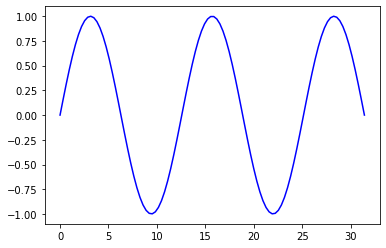

In [58]:
import matplotlib.pyplot as plt
import numpy as np
  
x = np.linspace(0, 10*np.pi, 100)
y = np.sin(x)
  
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'b-')
  
for phase in np.linspace(0, 10*np.pi, 100):
    line1.set_ydata(np.sin(0.5 * x + phase))
    fig.canvas.draw()
    fig.canvas.flush_events()

In [19]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [20]:
trainee = pd.read_csv(os.path.join(root_detection_gt, 'train_filenames.txt'), names=['filename'])
testee = pd.read_csv(os.path.join(root_detection_gt, 'test_filenames.txt'), names=['filename'])
print(f"Общее количество классов: {len(class_dict)}")
print(f"В обучающей выборке {len(os.listdir('C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames/train'))} фото ({len(trainee)})")
print(f"В тестовой выборке {len(os.listdir('C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames/test'))} фото ({len(testee)})")

Общее количество классов: 198
В обучающей выборке 9065 фото (9065)
В тестовой выборке 3022 фото (3022)


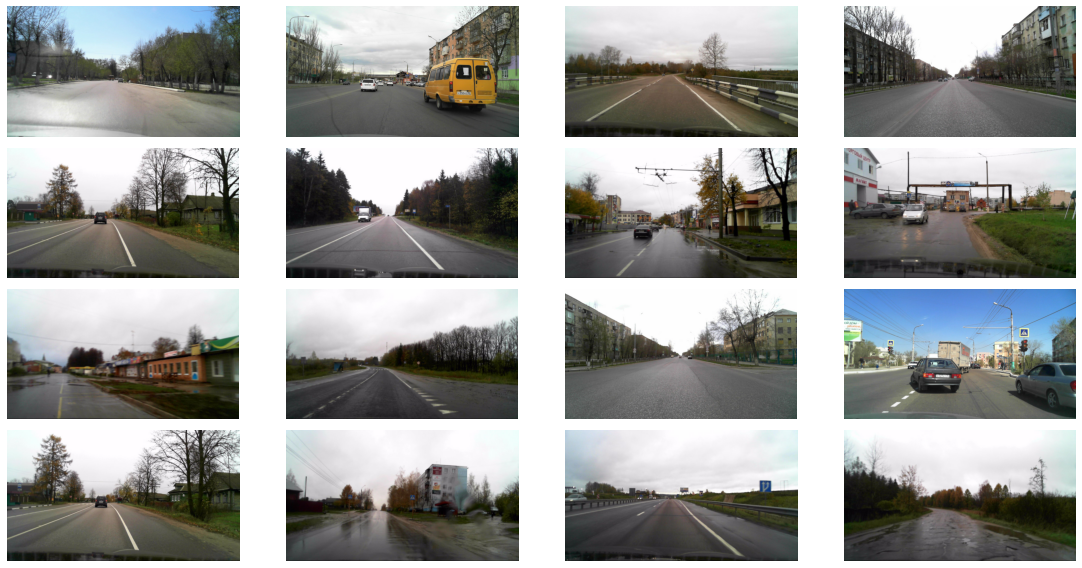

In [21]:
fig, axs = plt.subplots(4, 4, figsize=(16,8))

sample_gt = pd.read_csv(root_detection_gt + '/train_filenames.txt', names=['filename'], header=None)

for j in range(4):
    for i, name in zip(range(4), sample_gt.sample(4)['filename']):
        axs[j, i].imshow(plt.imread(f"C:/Users/yuras/Projects/Signs/data/detection/rtsd-d3-frames/train/{name}"))
        axs[j, i].axis('off')

fig.tight_layout()

# 6-Classes NET:
# blue_border, blue_rect, danger, main_roan, mandatory, prohibitory

## Transforms

In [22]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [23]:
train_dataset = RTSD_by_groups(root_image=root_detection_image, root_gt=root_detection_gt, train=True, transform=False)
test_dataset = RTSD_by_groups(root_image=root_detection_image, root_gt=root_detection_gt, train=False, transform=False)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2, shuffle=False)

In [23]:
model = models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [25]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [26]:
def do_training(model, data_loader, data_loader_test, num_epochs=4):
    # train on the GPU or on the CPU, if a GPU is not available
#     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

In [26]:
do_training(model=model, data_loader=train_loader, data_loader_test=test_loader)

Using device cpu
Epoch: [0]  [   0/4533]  eta: 1 day, 5:12:00  lr: 0.000010  loss: 0.6791 (0.6791)  loss_classifier: 0.5556 (0.5556)  loss_box_reg: 0.0419 (0.0419)  loss_objectness: 0.0749 (0.0749)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 23.1899  data: 0.4917  max mem: 0
Epoch: [0]  [  10/4533]  eta: 1 day, 5:47:18  lr: 0.000060  loss: 0.5527 (0.5202)  loss_classifier: 0.2797 (0.3360)  loss_box_reg: 0.0169 (0.0164)  loss_objectness: 0.0895 (0.1520)  loss_rpn_box_reg: 0.0075 (0.0157)  time: 23.7097  data: 0.1675  max mem: 0
Epoch: [0]  [  20/4533]  eta: 1 day, 6:29:12  lr: 0.000110  loss: 0.5200 (0.5043)  loss_classifier: 0.2916 (0.3381)  loss_box_reg: 0.0179 (0.0278)  loss_objectness: 0.0532 (0.1188)  loss_rpn_box_reg: 0.0100 (0.0195)  time: 24.3756  data: 0.1440  max mem: 0
Epoch: [0]  [  30/4533]  eta: 1 day, 7:17:43  lr: 0.000160  loss: 0.3684 (0.4588)  loss_classifier: 0.2723 (0.3130)  loss_box_reg: 0.0212 (0.0271)  loss_objectness: 0.0506 (0.1023)  loss_rpn_box_reg: 0.0076 (0.01

Epoch: [0]  [ 320/4533]  eta: 1 day, 7:26:17  lr: 0.001608  loss: 0.1323 (0.2084)  loss_classifier: 0.0529 (0.1232)  loss_box_reg: 0.0560 (0.0481)  loss_objectness: 0.0142 (0.0278)  loss_rpn_box_reg: 0.0047 (0.0094)  time: 24.0926  data: 0.1290  max mem: 0
Epoch: [0]  [ 330/4533]  eta: 1 day, 7:16:25  lr: 0.001658  loss: 0.1399 (0.2072)  loss_classifier: 0.0529 (0.1210)  loss_box_reg: 0.0466 (0.0477)  loss_objectness: 0.0173 (0.0289)  loss_rpn_box_reg: 0.0083 (0.0096)  time: 24.2435  data: 0.1333  max mem: 0
Epoch: [0]  [ 340/4533]  eta: 1 day, 7:06:35  lr: 0.001708  loss: 0.0916 (0.2044)  loss_classifier: 0.0270 (0.1186)  loss_box_reg: 0.0322 (0.0474)  loss_objectness: 0.0209 (0.0288)  loss_rpn_box_reg: 0.0058 (0.0096)  time: 24.2433  data: 0.1435  max mem: 0
Epoch: [0]  [ 350/4533]  eta: 1 day, 6:57:08  lr: 0.001758  loss: 0.0916 (0.2017)  loss_classifier: 0.0270 (0.1163)  loss_box_reg: 0.0381 (0.0478)  loss_objectness: 0.0128 (0.0282)  loss_rpn_box_reg: 0.0037 (0.0094)  time: 24.179

Epoch: [0]  [ 640/4533]  eta: 1 day, 3:27:47  lr: 0.003207  loss: 0.0923 (0.1634)  loss_classifier: 0.0277 (0.0844)  loss_box_reg: 0.0437 (0.0498)  loss_objectness: 0.0045 (0.0203)  loss_rpn_box_reg: 0.0032 (0.0089)  time: 23.8579  data: 0.1347  max mem: 0
Epoch: [0]  [ 650/4533]  eta: 1 day, 3:21:59  lr: 0.003257  loss: 0.0975 (0.1625)  loss_classifier: 0.0309 (0.0836)  loss_box_reg: 0.0459 (0.0498)  loss_objectness: 0.0023 (0.0202)  loss_rpn_box_reg: 0.0033 (0.0089)  time: 23.7643  data: 0.1378  max mem: 0
Epoch: [0]  [ 660/4533]  eta: 1 day, 3:16:20  lr: 0.003307  loss: 0.0975 (0.1618)  loss_classifier: 0.0318 (0.0830)  loss_box_reg: 0.0465 (0.0498)  loss_objectness: 0.0060 (0.0201)  loss_rpn_box_reg: 0.0073 (0.0089)  time: 23.8639  data: 0.1361  max mem: 0
Epoch: [0]  [ 670/4533]  eta: 1 day, 3:10:42  lr: 0.003357  loss: 0.0701 (0.1607)  loss_classifier: 0.0230 (0.0822)  loss_box_reg: 0.0352 (0.0496)  loss_objectness: 0.0060 (0.0200)  loss_rpn_box_reg: 0.0016 (0.0089)  time: 23.904

Epoch: [0]  [ 960/4533]  eta: 1 day, 0:40:34  lr: 0.004805  loss: 0.0770 (0.1469)  loss_classifier: 0.0273 (0.0699)  loss_box_reg: 0.0421 (0.0518)  loss_objectness: 0.0038 (0.0161)  loss_rpn_box_reg: 0.0038 (0.0091)  time: 23.6221  data: 0.1313  max mem: 0
Epoch: [0]  [ 970/4533]  eta: 1 day, 0:35:46  lr: 0.004855  loss: 0.0882 (0.1465)  loss_classifier: 0.0371 (0.0696)  loss_box_reg: 0.0435 (0.0519)  loss_objectness: 0.0038 (0.0160)  loss_rpn_box_reg: 0.0049 (0.0091)  time: 23.7547  data: 0.1327  max mem: 0
Epoch: [0]  [ 980/4533]  eta: 1 day, 0:30:52  lr: 0.004905  loss: 0.0846 (0.1458)  loss_classifier: 0.0371 (0.0692)  loss_box_reg: 0.0377 (0.0517)  loss_objectness: 0.0028 (0.0159)  loss_rpn_box_reg: 0.0046 (0.0090)  time: 23.6985  data: 0.1364  max mem: 0
Epoch: [0]  [ 990/4533]  eta: 1 day, 0:26:08  lr: 0.004955  loss: 0.0621 (0.1452)  loss_classifier: 0.0180 (0.0688)  loss_box_reg: 0.0335 (0.0516)  loss_objectness: 0.0030 (0.0158)  loss_rpn_box_reg: 0.0027 (0.0090)  time: 23.710

Epoch: [0]  [1290/4533]  eta: 22:05:56  lr: 0.005000  loss: 0.1149 (0.1377)  loss_classifier: 0.0352 (0.0619)  loss_box_reg: 0.0567 (0.0527)  loss_objectness: 0.0036 (0.0142)  loss_rpn_box_reg: 0.0038 (0.0089)  time: 23.2514  data: 0.1435  max mem: 0
Epoch: [0]  [1300/4533]  eta: 22:01:22  lr: 0.005000  loss: 0.1082 (0.1374)  loss_classifier: 0.0362 (0.0616)  loss_box_reg: 0.0629 (0.0527)  loss_objectness: 0.0026 (0.0141)  loss_rpn_box_reg: 0.0049 (0.0089)  time: 23.3132  data: 0.1421  max mem: 0
Epoch: [0]  [1310/4533]  eta: 21:56:47  lr: 0.005000  loss: 0.0717 (0.1369)  loss_classifier: 0.0219 (0.0614)  loss_box_reg: 0.0380 (0.0526)  loss_objectness: 0.0010 (0.0140)  loss_rpn_box_reg: 0.0019 (0.0089)  time: 23.3490  data: 0.1317  max mem: 0
Epoch: [0]  [1320/4533]  eta: 21:52:11  lr: 0.005000  loss: 0.0734 (0.1366)  loss_classifier: 0.0245 (0.0612)  loss_box_reg: 0.0347 (0.0526)  loss_objectness: 0.0010 (0.0140)  loss_rpn_box_reg: 0.0023 (0.0089)  time: 23.2794  data: 0.1317  max mem

Epoch: [0]  [1620/4533]  eta: 19:40:15  lr: 0.005000  loss: 0.1008 (0.1311)  loss_classifier: 0.0363 (0.0564)  loss_box_reg: 0.0496 (0.0531)  loss_objectness: 0.0046 (0.0127)  loss_rpn_box_reg: 0.0046 (0.0089)  time: 23.4129  data: 0.1324  max mem: 0
Epoch: [0]  [1630/4533]  eta: 19:35:52  lr: 0.005000  loss: 0.1008 (0.1310)  loss_classifier: 0.0322 (0.0563)  loss_box_reg: 0.0482 (0.0531)  loss_objectness: 0.0034 (0.0127)  loss_rpn_box_reg: 0.0037 (0.0089)  time: 23.2995  data: 0.1363  max mem: 0
Epoch: [0]  [1640/4533]  eta: 19:31:30  lr: 0.005000  loss: 0.0933 (0.1310)  loss_classifier: 0.0277 (0.0562)  loss_box_reg: 0.0462 (0.0532)  loss_objectness: 0.0015 (0.0126)  loss_rpn_box_reg: 0.0051 (0.0089)  time: 23.2158  data: 0.1423  max mem: 0
Epoch: [0]  [1650/4533]  eta: 19:27:05  lr: 0.005000  loss: 0.0933 (0.1310)  loss_classifier: 0.0277 (0.0561)  loss_box_reg: 0.0475 (0.0534)  loss_objectness: 0.0018 (0.0126)  loss_rpn_box_reg: 0.0054 (0.0090)  time: 23.1183  data: 0.1316  max mem

Epoch: [0]  [1950/4533]  eta: 17:21:02  lr: 0.005000  loss: 0.0760 (0.1271)  loss_classifier: 0.0234 (0.0529)  loss_box_reg: 0.0427 (0.0533)  loss_objectness: 0.0017 (0.0120)  loss_rpn_box_reg: 0.0019 (0.0089)  time: 23.4657  data: 0.1253  max mem: 0
Epoch: [0]  [1960/4533]  eta: 17:16:54  lr: 0.005000  loss: 0.0857 (0.1270)  loss_classifier: 0.0231 (0.0529)  loss_box_reg: 0.0449 (0.0533)  loss_objectness: 0.0029 (0.0119)  loss_rpn_box_reg: 0.0056 (0.0089)  time: 23.5920  data: 0.1387  max mem: 0
Epoch: [0]  [1970/4533]  eta: 17:12:46  lr: 0.005000  loss: 0.0909 (0.1269)  loss_classifier: 0.0286 (0.0528)  loss_box_reg: 0.0542 (0.0533)  loss_objectness: 0.0017 (0.0119)  loss_rpn_box_reg: 0.0058 (0.0089)  time: 23.7083  data: 0.1404  max mem: 0
Epoch: [0]  [1980/4533]  eta: 17:08:39  lr: 0.005000  loss: 0.0785 (0.1266)  loss_classifier: 0.0214 (0.0526)  loss_box_reg: 0.0401 (0.0532)  loss_objectness: 0.0017 (0.0118)  loss_rpn_box_reg: 0.0021 (0.0089)  time: 23.7464  data: 0.1348  max mem

Epoch: [0]  [2280/4533]  eta: 15:04:04  lr: 0.005000  loss: 0.0877 (0.1243)  loss_classifier: 0.0244 (0.0501)  loss_box_reg: 0.0458 (0.0535)  loss_objectness: 0.0037 (0.0117)  loss_rpn_box_reg: 0.0041 (0.0089)  time: 23.2707  data: 0.1317  max mem: 0
Epoch: [0]  [2290/4533]  eta: 14:59:54  lr: 0.005000  loss: 0.0877 (0.1241)  loss_classifier: 0.0226 (0.0500)  loss_box_reg: 0.0458 (0.0535)  loss_objectness: 0.0049 (0.0117)  loss_rpn_box_reg: 0.0050 (0.0089)  time: 23.0799  data: 0.1342  max mem: 0
Epoch: [0]  [2300/4533]  eta: 14:55:47  lr: 0.005000  loss: 0.0670 (0.1240)  loss_classifier: 0.0180 (0.0499)  loss_box_reg: 0.0341 (0.0535)  loss_objectness: 0.0035 (0.0116)  loss_rpn_box_reg: 0.0051 (0.0089)  time: 23.2878  data: 0.1436  max mem: 0
Epoch: [0]  [2310/4533]  eta: 14:51:59  lr: 0.005000  loss: 0.0733 (0.1239)  loss_classifier: 0.0215 (0.0498)  loss_box_reg: 0.0410 (0.0535)  loss_objectness: 0.0037 (0.0116)  loss_rpn_box_reg: 0.0035 (0.0089)  time: 24.3958  data: 0.1471  max mem

Epoch: [0]  [2610/4533]  eta: 13:14:51  lr: 0.005000  loss: 0.0546 (0.1196)  loss_classifier: 0.0179 (0.0474)  loss_box_reg: 0.0363 (0.0527)  loss_objectness: 0.0016 (0.0109)  loss_rpn_box_reg: 0.0023 (0.0086)  time: 27.2507  data: 0.1510  max mem: 0
Epoch: [0]  [2620/4533]  eta: 13:11:05  lr: 0.005000  loss: 0.0823 (0.1195)  loss_classifier: 0.0179 (0.0473)  loss_box_reg: 0.0458 (0.0527)  loss_objectness: 0.0020 (0.0109)  loss_rpn_box_reg: 0.0031 (0.0086)  time: 27.5620  data: 0.1614  max mem: 0
Epoch: [0]  [2630/4533]  eta: 13:07:19  lr: 0.005000  loss: 0.1105 (0.1195)  loss_classifier: 0.0278 (0.0473)  loss_box_reg: 0.0608 (0.0527)  loss_objectness: 0.0047 (0.0108)  loss_rpn_box_reg: 0.0045 (0.0087)  time: 27.8550  data: 0.1680  max mem: 0
Epoch: [0]  [2640/4533]  eta: 13:03:33  lr: 0.005000  loss: 0.1017 (0.1194)  loss_classifier: 0.0365 (0.0473)  loss_box_reg: 0.0481 (0.0527)  loss_objectness: 0.0010 (0.0108)  loss_rpn_box_reg: 0.0034 (0.0086)  time: 27.8902  data: 0.1622  max mem

Epoch: [0]  [2940/4533]  eta: 11:08:49  lr: 0.005000  loss: 0.0621 (0.1162)  loss_classifier: 0.0209 (0.0454)  loss_box_reg: 0.0245 (0.0523)  loss_objectness: 0.0036 (0.0102)  loss_rpn_box_reg: 0.0043 (0.0084)  time: 28.6694  data: 0.1675  max mem: 0
Epoch: [0]  [2950/4533]  eta: 11:04:46  lr: 0.005000  loss: 0.1004 (0.1162)  loss_classifier: 0.0191 (0.0453)  loss_box_reg: 0.0545 (0.0523)  loss_objectness: 0.0036 (0.0102)  loss_rpn_box_reg: 0.0071 (0.0084)  time: 27.2568  data: 0.1695  max mem: 0
Epoch: [0]  [2960/4533]  eta: 11:00:44  lr: 0.005000  loss: 0.0792 (0.1161)  loss_classifier: 0.0191 (0.0453)  loss_box_reg: 0.0502 (0.0522)  loss_objectness: 0.0022 (0.0102)  loss_rpn_box_reg: 0.0032 (0.0083)  time: 26.9171  data: 0.1581  max mem: 0
Epoch: [0]  [2970/4533]  eta: 10:56:43  lr: 0.005000  loss: 0.0665 (0.1160)  loss_classifier: 0.0162 (0.0452)  loss_box_reg: 0.0346 (0.0522)  loss_objectness: 0.0012 (0.0102)  loss_rpn_box_reg: 0.0032 (0.0084)  time: 27.1635  data: 0.1546  max mem

Epoch: [0]  [3270/4533]  eta: 9:01:14  lr: 0.005000  loss: 0.0688 (0.1141)  loss_classifier: 0.0223 (0.0439)  loss_box_reg: 0.0343 (0.0523)  loss_objectness: 0.0011 (0.0097)  loss_rpn_box_reg: 0.0035 (0.0082)  time: 40.1301  data: 0.2349  max mem: 0
Epoch: [0]  [3280/4533]  eta: 8:57:20  lr: 0.005000  loss: 0.0842 (0.1141)  loss_classifier: 0.0295 (0.0439)  loss_box_reg: 0.0423 (0.0523)  loss_objectness: 0.0016 (0.0097)  loss_rpn_box_reg: 0.0031 (0.0082)  time: 39.9869  data: 0.2421  max mem: 0
Epoch: [0]  [3290/4533]  eta: 8:53:05  lr: 0.005000  loss: 0.1062 (0.1140)  loss_classifier: 0.0297 (0.0438)  loss_box_reg: 0.0516 (0.0523)  loss_objectness: 0.0016 (0.0097)  loss_rpn_box_reg: 0.0031 (0.0082)  time: 29.0544  data: 0.1833  max mem: 0
Epoch: [0]  [3300/4533]  eta: 8:48:51  lr: 0.005000  loss: 0.0455 (0.1138)  loss_classifier: 0.0240 (0.0438)  loss_box_reg: 0.0217 (0.0522)  loss_objectness: 0.0011 (0.0097)  loss_rpn_box_reg: 0.0032 (0.0082)  time: 26.5966  data: 0.1600  max mem: 0


Epoch: [0]  [3600/4533]  eta: 6:40:10  lr: 0.005000  loss: 0.0581 (0.1113)  loss_classifier: 0.0248 (0.0423)  loss_box_reg: 0.0345 (0.0516)  loss_objectness: 0.0015 (0.0094)  loss_rpn_box_reg: 0.0040 (0.0081)  time: 23.3308  data: 0.1300  max mem: 0
Epoch: [0]  [3610/4533]  eta: 6:35:47  lr: 0.005000  loss: 0.0828 (0.1113)  loss_classifier: 0.0215 (0.0422)  loss_box_reg: 0.0492 (0.0516)  loss_objectness: 0.0015 (0.0094)  loss_rpn_box_reg: 0.0030 (0.0081)  time: 23.2469  data: 0.1320  max mem: 0
Epoch: [0]  [3620/4533]  eta: 6:31:23  lr: 0.005000  loss: 0.0738 (0.1112)  loss_classifier: 0.0214 (0.0422)  loss_box_reg: 0.0492 (0.0516)  loss_objectness: 0.0007 (0.0094)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 23.2520  data: 0.1339  max mem: 0
Epoch: [0]  [3630/4533]  eta: 6:27:00  lr: 0.005000  loss: 0.0761 (0.1111)  loss_classifier: 0.0247 (0.0422)  loss_box_reg: 0.0510 (0.0516)  loss_objectness: 0.0015 (0.0093)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 23.2801  data: 0.1267  max mem: 0


Epoch: [0]  [3930/4533]  eta: 4:16:45  lr: 0.005000  loss: 0.0902 (0.1093)  loss_classifier: 0.0243 (0.0410)  loss_box_reg: 0.0621 (0.0513)  loss_objectness: 0.0009 (0.0090)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 23.7186  data: 0.1385  max mem: 0
Epoch: [0]  [3940/4533]  eta: 4:12:27  lr: 0.005000  loss: 0.1062 (0.1092)  loss_classifier: 0.0239 (0.0410)  loss_box_reg: 0.0664 (0.0513)  loss_objectness: 0.0015 (0.0090)  loss_rpn_box_reg: 0.0057 (0.0079)  time: 23.6903  data: 0.1369  max mem: 0
Epoch: [0]  [3950/4533]  eta: 4:08:09  lr: 0.005000  loss: 0.0762 (0.1092)  loss_classifier: 0.0205 (0.0410)  loss_box_reg: 0.0477 (0.0513)  loss_objectness: 0.0016 (0.0090)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 23.7197  data: 0.1323  max mem: 0
Epoch: [0]  [3960/4533]  eta: 4:03:51  lr: 0.005000  loss: 0.0762 (0.1092)  loss_classifier: 0.0220 (0.0410)  loss_box_reg: 0.0471 (0.0514)  loss_objectness: 0.0019 (0.0090)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 23.7508  data: 0.1380  max mem: 0


Epoch: [0]  [4260/4533]  eta: 1:55:36  lr: 0.005000  loss: 0.0832 (0.1077)  loss_classifier: 0.0256 (0.0401)  loss_box_reg: 0.0524 (0.0511)  loss_objectness: 0.0019 (0.0086)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 23.6525  data: 0.1355  max mem: 0
Epoch: [0]  [4270/4533]  eta: 1:51:21  lr: 0.005000  loss: 0.0746 (0.1076)  loss_classifier: 0.0241 (0.0401)  loss_box_reg: 0.0321 (0.0511)  loss_objectness: 0.0008 (0.0086)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 23.6726  data: 0.1331  max mem: 0
Epoch: [0]  [4280/4533]  eta: 1:47:06  lr: 0.005000  loss: 0.0788 (0.1076)  loss_classifier: 0.0218 (0.0401)  loss_box_reg: 0.0321 (0.0511)  loss_objectness: 0.0008 (0.0086)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 23.7705  data: 0.1308  max mem: 0
Epoch: [0]  [4290/4533]  eta: 1:42:51  lr: 0.005000  loss: 0.0788 (0.1075)  loss_classifier: 0.0218 (0.0400)  loss_box_reg: 0.0410 (0.0511)  loss_objectness: 0.0029 (0.0086)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 23.7747  data: 0.1305  max mem: 0


NameError: name 'evaluate' is not defined

In [27]:
datata = full_gt

In [28]:
img = 'autosave01_02_2012_09_16_57.jpg' #autosave01_02_2012_09_16_57
img_path = root_detection_image + '/train/' + img
boxes = []
labels = []

if img in list(datata['filename']):
    num_objs = datata['filename'].value_counts()[img]
            
    box = []
                    
    for _, row in datata[datata['filename'] == img].items():
        box.append(list(row))
                    
    for i in range(num_objs):
        bbox = [box[1][i], box[2][i], box[3][i]+box[1][i], box[4][i]+box[2][i]]
        boxes.append(bbox)
if len(boxes) == 1:
    boxes = [boxes[0],]
boxes = torch.as_tensor(boxes, dtype=torch.float32)
labels = torch.tensor([4, 5])
img = Image.open(img_path).convert('RGB')
print(boxes)
print(labels)

tensor([[170., 421., 192., 442.]])
tensor([4, 5])


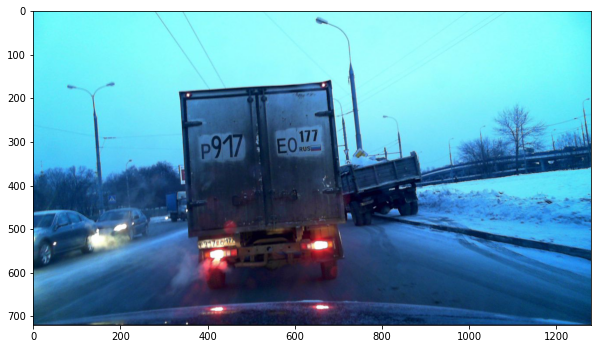

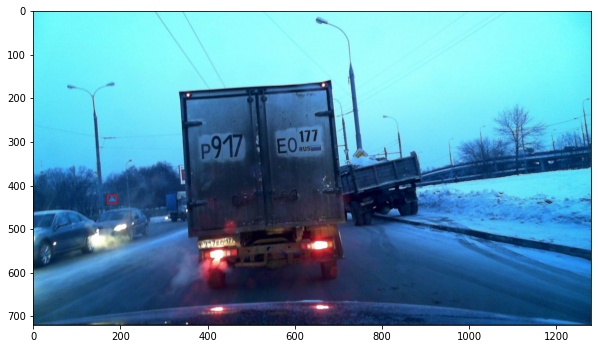

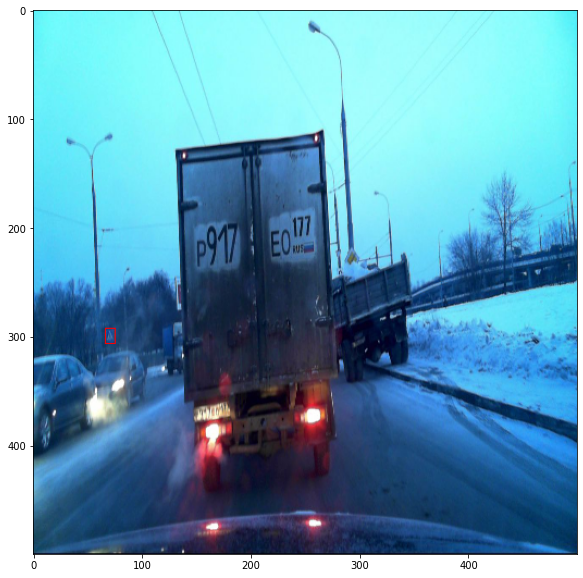

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(img)
show_img_with_bb(img, boxes, 2)
rs_img, rs_boxes = Resize_img_bb(img, boxes, (500, 500))
show_img_with_bb(rs_img, rs_boxes, 1)b

In [52]:
abab = torch.tensor([1.,2.,45.])
abab[1]

tensor(2.)

In [30]:
boxes

tensor([[170., 421., 192., 442.]])

In [ ]:
img_cv = cv2.imread(img_path)
cv2.imshow("original", img_cv)
for i, box in enumerate(boxes):
    cropped_img_cv = img_cv[box[1].to(torch.int32):box[3].to(torch.int32), box[0].to(torch.int32):box[2].to(torch.int32)]
    cv2.imshow("cropped"+str(i), cropped_img_cv)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
def crop(img, boxes):
    """Convert img to cv2-format, crop it and convert back to PIL-format"""
    
    cropped_imgs = []
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    for box in boxes:
        box = box.to(torch.int32)
        cropped_img = img[box[1]:box[3], box[0]:box[2]]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_imgs.append(cropped_img)
        
    return cropped_imgs

In [ ]:
cropped_img = crop(img, boxes)
for i in cropped_img:
    plt.imshow(i)

## Вспомогательные функции

In [ ]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        #val_acc = valid(res_model,criterion,optimizer,val_loader)
        #val_score.at[i] = val_acc
    
    return train_score,val_score

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()
            imgs = imgs.cuda()
            labels = labels.cuda()
            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
def train_MyNet(model, train_loader, val_loader, criterion, optimizer, save_path, n_epochs=30):
    
    """ВОЗВРАЩАЕТ ОБУЧЕННУЮ МОДЕЛЬ"""
    val_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        since = time.time()
        train_loss_list = list()
        train_acc = list()
        val_loss_list = list()
        val_acc = list()
        
        #TRAIN DATASET
        
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            #ПРЯМОЙ ПРОХОД
            outputs = model(images, labels)
            train_loss = criterion(outputs, labels)
            train_loss_list.append(train_loss.item())
            
            #ОБРАТНОЕ РАСПРОСТРАНЕНИЕ ОШИБКИ И ОПТИМИЗАЦИЯ
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            #КОНТРОЛЬ ТОЧНОСТИ МОДЕЛИ
            train_total = labels.size(0)
            _, train_predicted = torch.max(outputs.data, 1)
            train_correct = (train_predicted == labels).sum().item()
            train_acc.append(train_correct / train_total)
        
        #VALID DATASET
        
        model.eval()
        for batch_idx, (images, labels) in enumerate(val_loader):
            #ПРЯМОЙ ПРОХОД
            outputs = model(images, labels)
            val_loss = criterion(outputs, labels)
            val_loss_list.append(val_loss.item())
            
            #КОНТРОЛЬ ТОЧНОСТИ МОДЕЛИ
            val_total = labels.size(0)
            _, val_predicted = torch.max(outputs.data, 1)
            val_correct = (val_predicted == labels).sum().item()
            val_acc.append(val_correct / val_total)   
            
        time_elapsed = time.time() - since
        print(f'Epoch [{epoch}/{n_epochs}] complete in {(time_elapsed // (60 * 60)):.0f}h {((time_elapsed / 60) % 60):.0f}m. Train Loss: {train_loss.item():.4f}, Valid Loss: {val_loss.item():.4f}, Train Accuracy: {((train_correct / train_total) * 100):.2f}%, Valid Accuracy: {((val_correct / val_total) * 100):.2f}%')
    
        if val_loss <= val_loss_min:
            torch.save(model.state_dict(), save_path)
            val_loss_min = val_loss
            print('Validation Loss decreased! Model saved.')
            
    return model

## Модель

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)

# model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
train_MyNet(model=model, train_loader=train_loader_rt, val_loader=valid_loader_rt, criterion=criterion, optimizer=optimizer, save_path='RT_weights.pth', n_epochs=5)

## Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader_rt):
    
#     imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

In [ ]:
valid_df["pred"] = valid_predicts

# Посчитаем точность модели

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
valid_df['pred'].values

In [ ]:
valid_df

In [ ]:
val_accuracy = recall_score(valid_df['red_triangles'].values, valid_df['pred'].values, average='macro', zero_division=0)
print(f"Validation accuracy = {val_accuracy}")